## 3.1线性回归

### 3.1.2矢量化加速

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.21993 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00100 sec'

### 3.1.3正态分布与平方损失

In [7]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

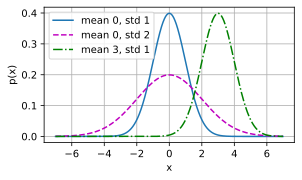

In [8]:
x = np.arange(-7, 7, 0.01)
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 3.2 线性回归的从零开始实现

In [9]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1生成数据集

    y = Xw + b + ϵ 

In [10]:
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [12]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [13]:
print('features:',features[0],'\nlabel:', labels[0])

features: tensor([0.9683, 1.1244]) 
label: tensor([2.3088])


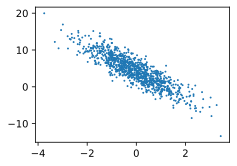

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2读取数据集

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        

In [16]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3792, -0.4535],
        [ 0.4290, -0.5162],
        [-1.4570, -0.8317],
        [ 1.0797, -0.4437],
        [ 1.5077,  0.3940],
        [-1.1657, -0.7698],
        [ 0.2042,  0.0723],
        [-0.4235,  0.6120],
        [ 1.0983, -1.3458],
        [-1.0955,  0.1373]]) 
 tensor([[ 6.4931],
        [ 6.8229],
        [ 4.1326],
        [ 7.8787],
        [ 5.8729],
        [ 4.4846],
        [ 4.3593],
        [ 1.2697],
        [10.9726],
        [ 1.5419]])


### 3.2.3初始化模型参数

In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4定义模型

In [21]:
def linreg(X, w, b): #@save
    return torch.matmul(X, w) + b

### 3.2.5定义损失函数

In [18]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6定义优化算法

In [19]:
def sgd(params, lr, batch_size): #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [23]:
for epoch in range(num_epochs):
    for (X, y) in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.025422
epoch 2, loss 0.000104
epoch 3, loss 0.000053


In [24]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0004, 0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


## 3.3线性回归的简单实现

### 3.3.1生成数据集

In [32]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2读取数据集

In [34]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造⼀个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [35]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [36]:
next(iter(data_iter))

[tensor([[-0.6920, -0.4082],
         [ 0.8208,  1.3574],
         [-1.3231, -1.3037],
         [-0.0105, -1.4816],
         [ 0.3312, -0.1241],
         [ 1.4825, -0.3750],
         [-0.4458, -0.5894],
         [ 0.7596, -0.7799],
         [-1.0070,  0.3202],
         [-0.9513,  0.4104]]),
 tensor([[4.2146],
         [1.2361],
         [5.9808],
         [9.2045],
         [5.2578],
         [8.4405],
         [5.3160],
         [8.3808],
         [1.1012],
         [0.9011]])]

### 3.3.3 定义模型

In [37]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

### 3.3.4初始化模型参数

In [39]:
net[0]

Linear(in_features=2, out_features=1, bias=True)

In [40]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [44]:
loss = nn.MSELoss()

### 3.3.6定义优化算法

In [42]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练

In [45]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000187
epoch 2, loss 0.000098
epoch 3, loss 0.000099


In [46]:
w = net[0].weight.data
print('w的估计误差： ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差： ', true_b - b)

w的估计误差：  tensor([-0.0009, -0.0005])
b的估计误差：  tensor([0.0003])


## 3.4 softmax回归